In [12]:
import numpy as np
import xarray as xr
import salishsea_tools.river_202108 as rivers
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [4]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

In [73]:
fw_rivers_subset

<xarray.Dataset>
Dimensions:          (time: 732, depth: 40, gridY: 898, gridX: 398)
Coordinates:
  * time             (time) datetime64[ns] 2012-01-01T12:00:00 ... 2014-01-01...
  * depth            (depth) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
  * gridY            (gridY) int64 0 1 2 3 4 5 6 ... 891 892 893 894 895 896 897
  * gridX            (gridX) int64 0 1 2 3 4 5 6 ... 391 392 393 394 395 396 397
Data variables:
    nooksack_river   (time, depth, gridY, gridX) float32 ...
    skagit_river     (time, depth, gridY, gridX) float32 ...
    snohomish_river  (time, depth, gridY, gridX) float32 ...
    nisqually_river  (time, depth, gridY, gridX) float32 ...
    elwha_river      (time, depth, gridY, gridX) float32 ...
    cowichan_river   (time, depth, gridY, gridX) float32 ...
    nanaimo_river    (time, depth, gridY, gridX) float32 ...
    puntledge_river  (time, depth, gridY, gridX) float32 ...
    salmon_river     (time, depth, gridY, gridX) float32 ...
    homathko_river   (time, depth, gridY, gridX) float32 ...
    squamish_river   (time, depth, gridY, gridX) float32 ...
Attributes:
    name:         SalishSeaCast_river_trace_day_avg_subset_all_20120101_20140101
    description:  Day-averaged river dye extracted from SalishSeaCast v202111...
    history:      2024-03-11 14:41 -07:00: Generated by `reshapr extract /oce...
    Conventions:  CF-1.6

In [84]:
fw_rivers_fraser = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_Fraser_all_20120101_20140101.nc')
fw_rivers_subset = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_subset_all_20120101_20140101.nc')
fw_rivers_other = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_other_all_20120101_20140101.nc')

# time = fw_rivers_fraser['time'].to_numpy()
fraser_file = '1d_hindcast_volume_fraser_river_s2012_732_dep_0_40.csv'
fraser_arr = pd.read_csv('dye_to_vol/' + fraser_file)['0'].to_numpy()

nooksack_file = '1d_hindcast_volume_nooksack_river_s2012_732_dep_0_40.csv'
nooksack_arr = pd.read_csv('dye_to_vol/' + nooksack_file)['0'].to_numpy()

skagit_file = '1d_hindcast_volume_skagit_river_s2012_732_dep_0_40.csv'
skagit_arr = pd.read_csv('dye_to_vol/' + skagit_file)['0'].to_numpy()

snohomish_file = '1d_hindcast_volume_snohomish_river_s2012_732_dep_0_40.csv'
snohomish_arr = pd.read_csv('dye_to_vol/' + snohomish_file)['0'].to_numpy()

nisqually_file = '1d_hindcast_volume_nisqually_river_s2012_732_dep_0_40.csv'
nisqually_arr = pd.read_csv('dye_to_vol/' + nisqually_file)['0'].to_numpy()

elwha_file = '1d_hindcast_volume_elwha_river_s2012_732_dep_0_40.csv'
elwha_arr = pd.read_csv('dye_to_vol/' + elwha_file)['0'].to_numpy()

cowichan_file = '1d_hindcast_volume_cowichan_river_s2012_732_dep_0_40.csv'
cowichan_arr = pd.read_csv('dye_to_vol/' + cowichan_file)['0'].to_numpy()

nanaimo_file = '1d_hindcast_volume_nanaimo_river_s2012_732_dep_0_40.csv'
nanaimo_arr = pd.read_csv('dye_to_vol/' + nanaimo_file)['0'].to_numpy()

puntledge_file = '1d_hindcast_volume_puntledge_river_s2012_732_dep_0_40.csv'
puntledge_arr = pd.read_csv('dye_to_vol/' + puntledge_file)['0'].to_numpy()

salmon_file = '1d_hindcast_volume_salmon_river_s2012_732_dep_0_40.csv'
salmon_arr = pd.read_csv('dye_to_vol/' + salmon_file)['0'].to_numpy()

homathko_file = '1d_hindcast_volume_homathko_river_s2012_732_dep_0_40.csv'
homathko_arr = pd.read_csv('dye_to_vol/' + homathko_file)['0'].to_numpy()

# squamish_file = '1d_hindcast_volume_squamish_river_s2012_732_dep_0_40.csv'
# squamish_arr = pd.read_csv('dye_to_vol/' + squamish_file)['0'].to_numpy()

In [ ]:
Fraser_mod = pd.read_csv('river_dailies_to_ts_Fraser_20120101_20150101.csv')
Fraser_mod['date'] = pd.to_datetime(Fraser_mod['date'], format='%m-%d-%Y')

rho = 1026
runoff_to_m3 = 86400 * (500*440)/rho

## Exponential Fits

In [52]:
def days_vols(idxs, ds, arr):
    days = [ds['time'][idxs[0]], ds['time'][idxs[1]], ds['time'][idxs[2]]]
    vols = [arr[idxs[0]], arr[idxs[1]], arr[idxs[2]]]
    return days, vols

In [13]:
def model(t, A, T):
    return A * (1 - np.exp(-t / T))

In [14]:
def model_inv(y, A, T):
    return -T * np.log(1 - (y/A))

In [58]:
def fit_and_plot(initial_guess, t_data, Y_data, region):
    popt, pcov = curve_fit(model, t_data, Y_data, p0=initial_guess)
    A_opt, T_opt = popt

    T_80pct = model_inv(A_opt*0.8, A_opt, T_opt)
    T_90pct = model_inv(A_opt*0.9, A_opt, T_opt)
    T_95pct = model_inv(A_opt*0.95, A_opt, T_opt)
    T_99pct = model_inv(A_opt*0.99, A_opt, T_opt)

    print("Optimized parameters:")
    print("A = {:.0f} m^3".format(A_opt))
    print("T = {:.0f} days, {:.2f} years".format(T_opt, T_opt/365))
    print('T_80pct = {:.2f} years'.format(T_80pct/365))
    print('T_90pct = {:.2f} years'.format(T_90pct/365))
    print('T_95pct = {:.2f} years'.format(T_95pct/365))
    print('T_99pct = {:.2f} years'.format(T_99pct/365))

    # Generate the fitted curve
    t_fit = np.linspace(0, max(t_data)*2, 100)
    Y_fit = model(t_fit, A_opt, T_opt)

    # Plot the original data and the fitted curve
    plt.plot(t_data, Y_data, 'bo', label='Data')
    plt.plot(t_fit, Y_fit, 'r-', label='Fitted curve')
    plt.vlines([T_opt, T_80pct, T_90pct, T_95pct, T_99pct], [0, 0, 0, 0, 0], [A_opt, A_opt, A_opt, A_opt, A_opt], 'k', linestyle='--', alpha=0.5)
    plt.xlabel('t: Days since start of run')
    plt.ylabel(r'Y: $m^3$ freshwater')
    plt.legend()
    plt.title('{} Exponential Fit'.format(region))
    plt.show()

    return A_opt, T_opt

In [56]:
idxs = [0, 366, 731]

Optimized parameters:
A = 65977131694 m^3
T = 289 days, 0.79 years
T_80pct = 1.27 years
T_90pct = 1.82 years
T_95pct = 2.37 years
T_99pct = 3.65 years


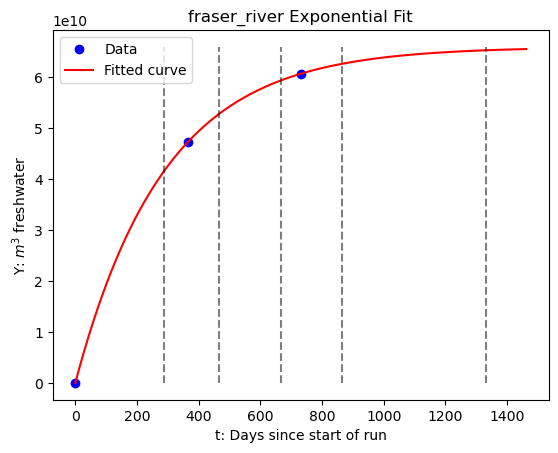

In [59]:
variable = 'fraser_river'
days, vols = days_vols(idxs, fw_rivers_fraser, fraser_arr)
A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)

Optimized parameters:
A = 311375649 m^3
T = 16 days, 0.04 years
T_80pct = 0.07 years
T_90pct = 0.10 years
T_95pct = 0.13 years
T_99pct = 0.20 years


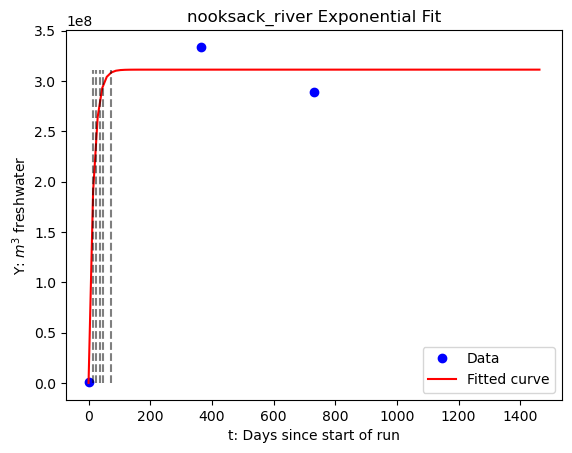

Optimized parameters:
A = 311528648 m^3
T = 182 days, 0.50 years
T_80pct = 0.80 years
T_90pct = 1.15 years
T_95pct = 1.49 years
T_99pct = 2.30 years


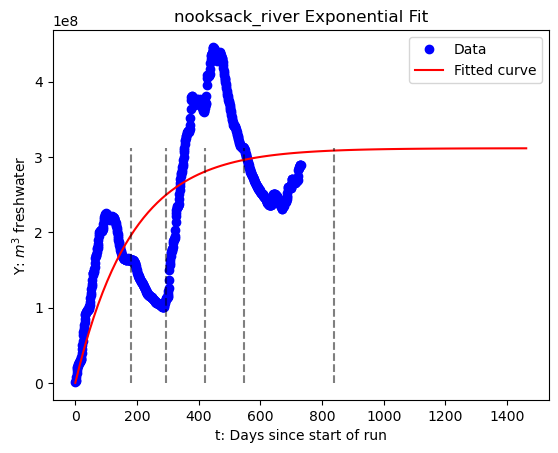

In [71]:
variable = 'nooksack_river'
days, vols = days_vols(idxs, fw_rivers_subset, nooksack_arr)
A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(nooksack_arr)), Y_data=nooksack_arr, region=variable)

Optimized parameters:
A = 3110656049 m^3
T = 107 days, 0.29 years
T_80pct = 0.47 years
T_90pct = 0.68 years
T_95pct = 0.88 years
T_99pct = 1.35 years


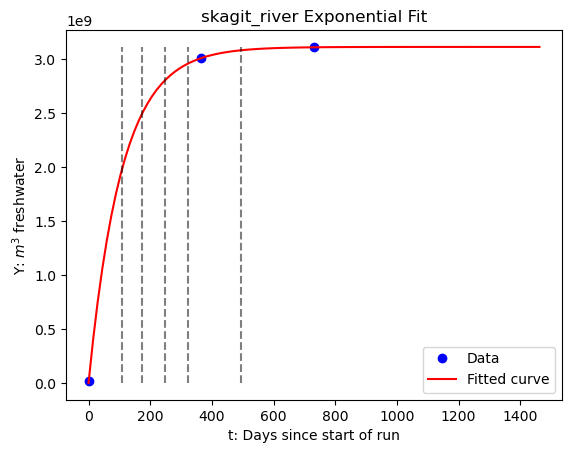

Optimized parameters:
A = 3173156726 m^3
T = 159 days, 0.44 years
T_80pct = 0.70 years
T_90pct = 1.00 years
T_95pct = 1.30 years
T_99pct = 2.00 years


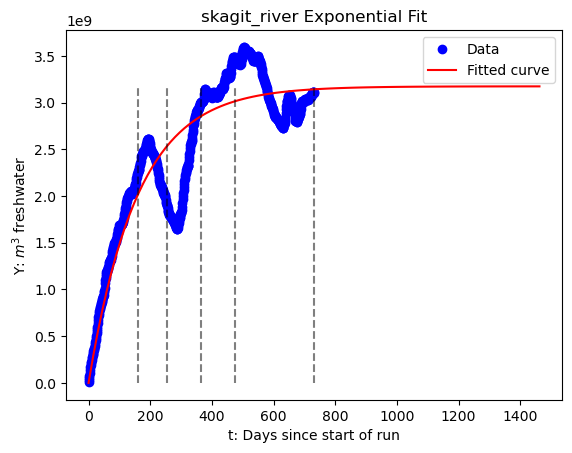

In [76]:
variable = 'skagit_river'
days, vols = days_vols(idxs, fw_rivers_subset, skagit_arr)
A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(skagit_arr)), Y_data=skagit_arr, region=variable)

Optimized parameters:
A = 4607652814 m^3
T = 118 days, 0.32 years
T_80pct = 0.52 years
T_90pct = 0.74 years
T_95pct = 0.97 years
T_99pct = 1.49 years


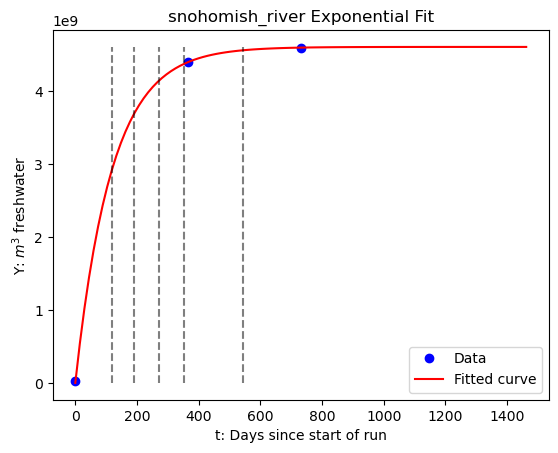

Optimized parameters:
A = 4766285632 m^3
T = 169 days, 0.46 years
T_80pct = 0.74 years
T_90pct = 1.07 years
T_95pct = 1.39 years
T_99pct = 2.13 years


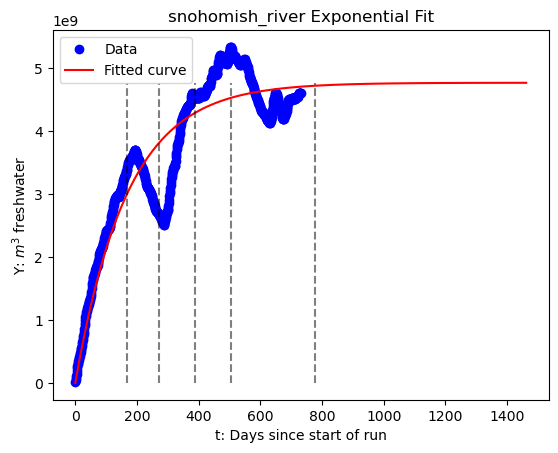

In [77]:
variable = 'snohomish_river'
days, vols = days_vols(idxs, fw_rivers_subset, snohomish_arr)
A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(snohomish_arr)), Y_data=snohomish_arr, region=variable)

Optimized parameters:
A = 1848141723 m^3
T = 212 days, 0.58 years
T_80pct = 0.94 years
T_90pct = 1.34 years
T_95pct = 1.74 years
T_99pct = 2.68 years


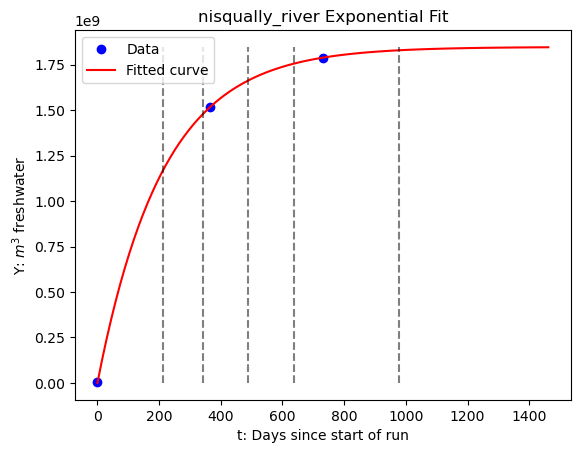

Optimized parameters:
A = 1701468662 m^3
T = 119 days, 0.33 years
T_80pct = 0.52 years
T_90pct = 0.75 years
T_95pct = 0.97 years
T_99pct = 1.50 years


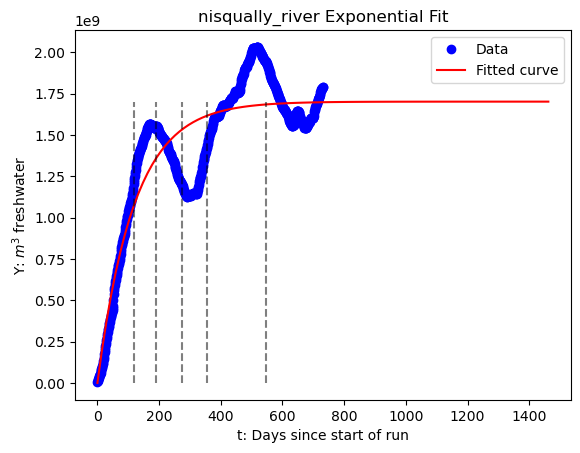

In [78]:
variable = 'nisqually_river'
days, vols = days_vols(idxs, fw_rivers_subset, nisqually_arr)
A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(nisqually_arr)), Y_data=nisqually_arr, region=variable)

/home/cdonaldson/conda_envs/analysis-cassidy/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Optimized parameters:
A = 416020208 m^3
T = 12 days, 0.03 years
T_80pct = 0.05 years
T_90pct = 0.08 years
T_95pct = 0.10 years
T_99pct = 0.15 years


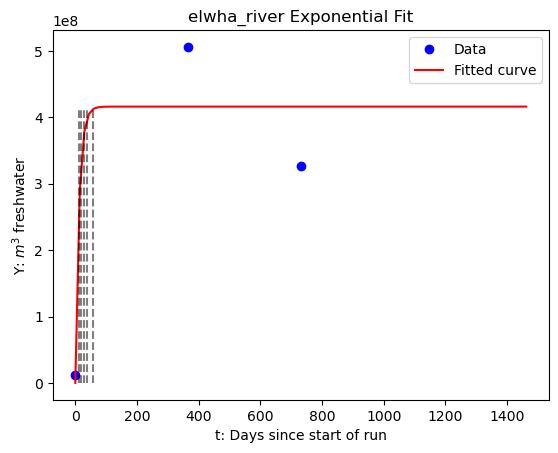

Optimized parameters:
A = 354414904 m^3
T = 15 days, 0.04 years
T_80pct = 0.07 years
T_90pct = 0.10 years
T_95pct = 0.13 years
T_99pct = 0.19 years


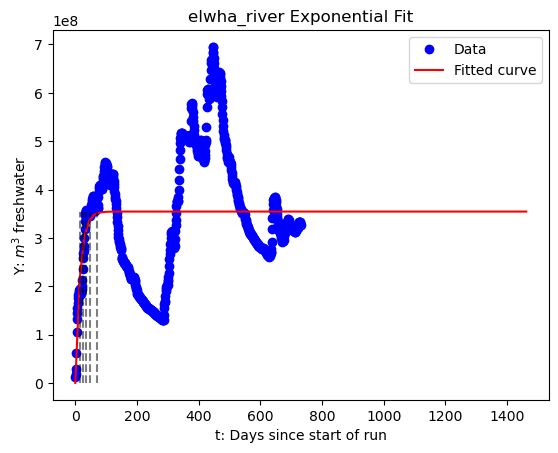

In [79]:
variable = 'elwha_river'
days, vols = days_vols(idxs, fw_rivers_subset, elwha_arr)
A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(elwha_arr)), Y_data=elwha_arr, region=variable)

Optimized parameters:
A = 413432763 m^3
T = 3 days, 0.01 years
T_80pct = 0.01 years
T_90pct = 0.02 years
T_95pct = 0.03 years
T_99pct = 0.04 years


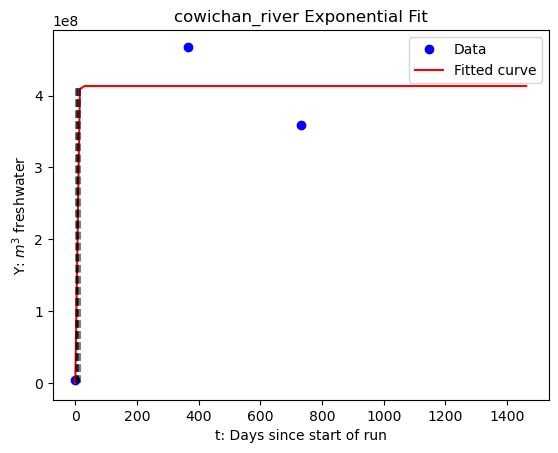

Optimized parameters:
A = 389663436 m^3
T = 41 days, 0.11 years
T_80pct = 0.18 years
T_90pct = 0.26 years
T_95pct = 0.34 years
T_99pct = 0.52 years


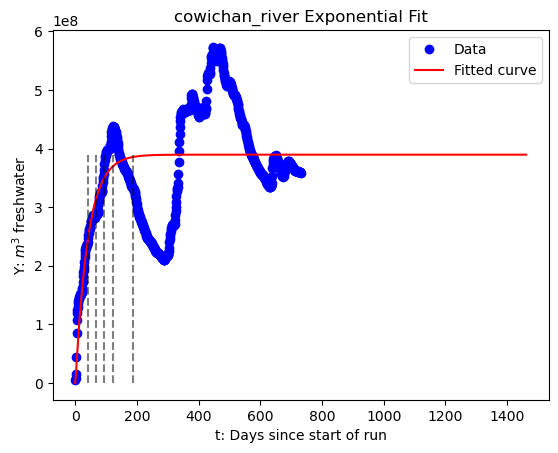

In [80]:
variable = 'cowichan_river'
days, vols = days_vols(idxs, fw_rivers_subset, cowichan_arr)
A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(cowichan_arr)), Y_data=cowichan_arr, region=variable)

Optimized parameters:
A = 481508675 m^3
T = 9 days, 0.02 years
T_80pct = 0.04 years
T_90pct = 0.06 years
T_95pct = 0.07 years
T_99pct = 0.11 years


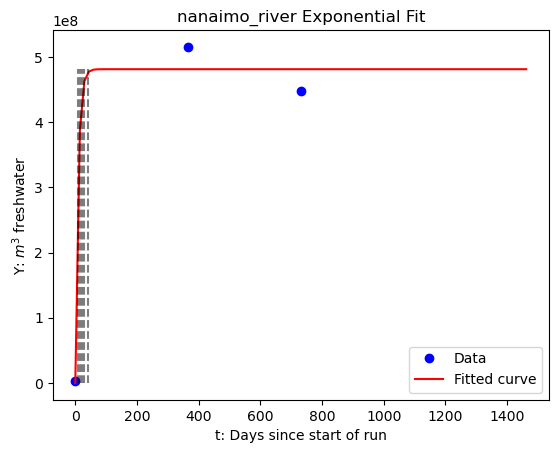

Optimized parameters:
A = 499309401 m^3
T = 80 days, 0.22 years
T_80pct = 0.35 years
T_90pct = 0.50 years
T_95pct = 0.65 years
T_99pct = 1.01 years


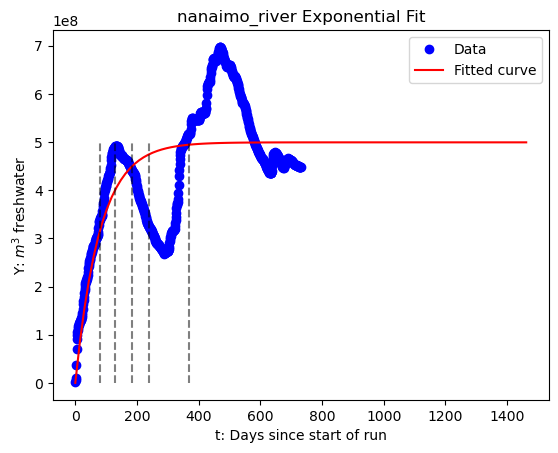

In [81]:
variable = 'nanaimo_river'
days, vols = days_vols(idxs, fw_rivers_subset, nanaimo_arr)
A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(nanaimo_arr)), Y_data=nanaimo_arr, region=variable)

Optimized parameters:
A = 839498240 m^3
T = 14 days, 0.04 years
T_80pct = 0.06 years
T_90pct = 0.09 years
T_95pct = 0.11 years
T_99pct = 0.18 years


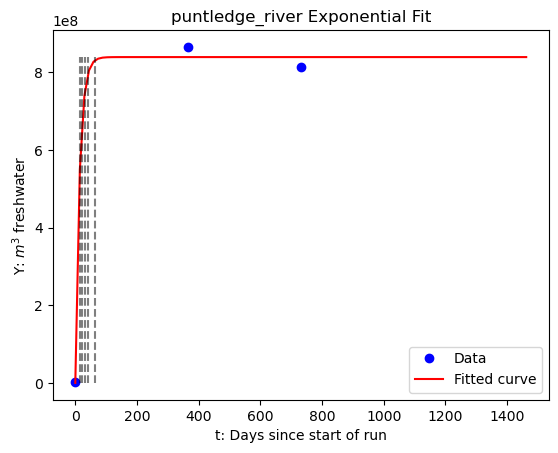

Optimized parameters:
A = 915141863 m^3
T = 98 days, 0.27 years
T_80pct = 0.43 years
T_90pct = 0.62 years
T_95pct = 0.80 years
T_99pct = 1.24 years


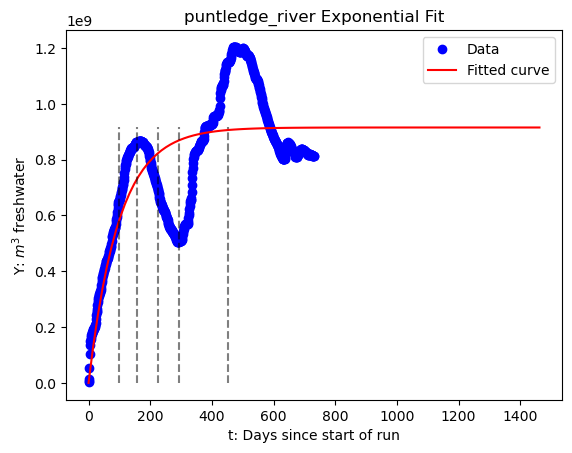

In [82]:
variable = 'puntledge_river'
days, vols = days_vols(idxs, fw_rivers_subset, puntledge_arr)
A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(puntledge_arr)), Y_data=puntledge_arr, region=variable)

Optimized parameters:
A = 445390321 m^3
T = 252 days, 0.69 years
T_80pct = 1.11 years
T_90pct = 1.59 years
T_95pct = 2.07 years
T_99pct = 3.18 years


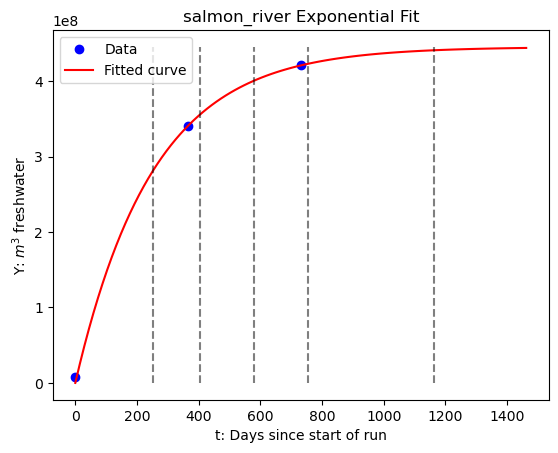

Optimized parameters:
A = 425327239 m^3
T = 147 days, 0.40 years
T_80pct = 0.65 years
T_90pct = 0.92 years
T_95pct = 1.20 years
T_99pct = 1.85 years


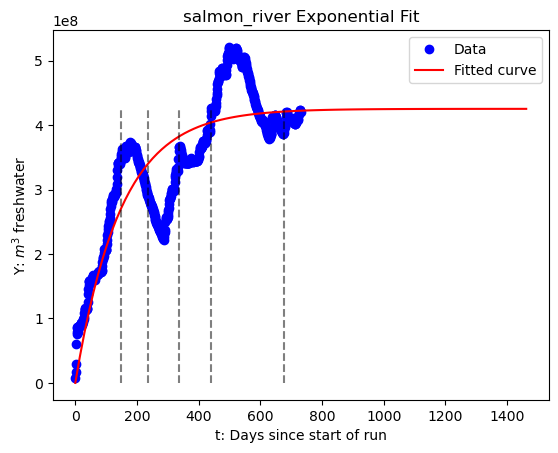

In [83]:
variable = 'salmon_river'
days, vols = days_vols(idxs, fw_rivers_subset, salmon_arr)
A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(salmon_arr)), Y_data=salmon_arr, region=variable)

Optimized parameters:
A = 11581142676 m^3
T = 465 days, 1.27 years
T_80pct = 2.05 years
T_90pct = 2.93 years
T_95pct = 3.81 years
T_99pct = 5.86 years


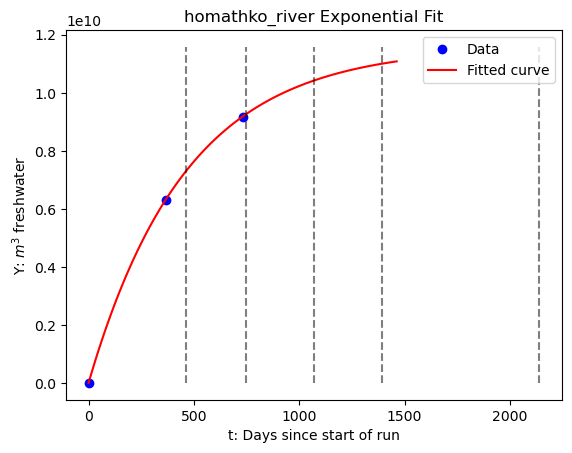

Optimized parameters:
A = 18652043440 m^3
T = 924 days, 2.53 years
T_80pct = 4.07 years
T_90pct = 5.83 years
T_95pct = 7.58 years
T_99pct = 11.66 years


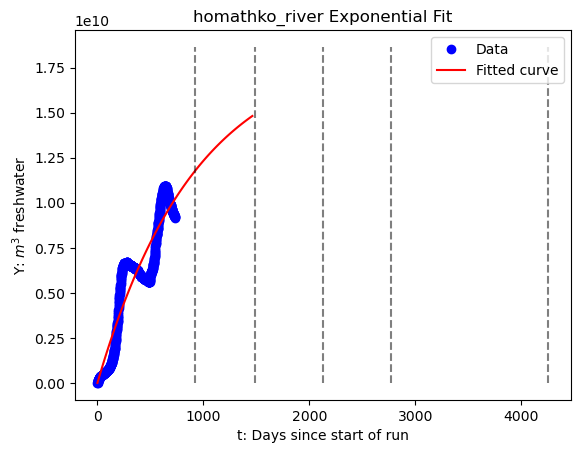

In [85]:
variable = 'homathko_river'
days, vols = days_vols(idxs, fw_rivers_subset, homathko_arr)
A_opt, T_opt = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt, T_opt = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(homathko_arr)), Y_data=homathko_arr, region=variable)